In [1]:
import tensorflow as tf
import numpy as np
import os
import time
import matplotlib.pyplot as plt

In [2]:
def draw_loss(train_loss):
    t = range(len(train_loss))
    plt.plot(t, train_loss, label='BPC')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [3]:
def draw_learning_curve(train_acc, val_acc):
    t = range(len(train_acc))
    plt.plot(t, train_acc, label='train')
    plt.plot(t, val_acc, label='val')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy rate')
    plt.legend()
    plt.show()

In [4]:
def data_process(seq_length, text_as_int, BATCH_SIZE = 1, BUFFER_SIZE = 10000):
    # Create training examples / targets
    char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
    sequences = char_dataset.batch(seq_length+1, drop_remainder=True)
    dataset = sequences.map(split_input_target)
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
    DATASET_SIZE = len(list(dataset))
    train_size = int(0.9 * DATASET_SIZE)
    val_size = int(0.1 * DATASET_SIZE)
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size)
    return train_dataset, val_dataset

In [5]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

In [6]:
def build_RNN_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim,batch_input_shape=[batch_size, None]))
    model.add(tf.keras.layers.SimpleRNN(rnn_units, return_sequences=True, stateful=True))
    model.add(tf.keras.layers.Dense(vocab_size))
    return model

In [7]:
def build_LSTM_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim,batch_input_shape=[batch_size, None]))
    model.add(tf.keras.layers.LSTM(rnn_units, return_sequences=True, stateful=True))
    model.add(tf.keras.layers.Dense(vocab_size))
    return model

In [8]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [9]:
def generate_text(model, start_string):
    path_to_file = 'shakespeare.txt'
    text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
    vocab = sorted(set(text))
    char2idx = {u:i for i, u in enumerate(vocab)}
    idx2char = np.array(vocab)
    text_as_int = np.array([char2idx[c] for c in text])
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 1000

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperature results in more predictable text.
    # Higher temperature results in more surprising text.
    # Experiment to find the best setting.
    temperature = 1

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [10]:
path_to_file = 'shakespeare.txt'
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
vocab = sorted(set(text))
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)
text_as_int = np.array([char2idx[c] for c in text])

In [11]:
total_loss = []
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024
seq_len = 100
BATCH_SIZE = 1
BUFFER_SIZE = 10000
EPOCHS = 10
for i in range (2):
    seq_len = 100
    for j in range (2):
        print('%d,%d' % (rnn_units, seq_len))
        train_dataset, val_dataset = data_process(seq_len, text_as_int, BATCH_SIZE = 1, BUFFER_SIZE = 10000)
        model = build_LSTM_model(vocab_size=len(vocab),embedding_dim=embedding_dim,rnn_units=rnn_units,batch_size=BATCH_SIZE)
        checkpoint_dir = './training_checkpoints_' + str(i) + str(j)
        checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
        checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,save_weights_only=True)
        model.compile(optimizer='adam', loss=loss)
        model.summary()
        history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])
        total_loss.append(history.history['loss'])
        seq_len = int(seq_len/2)
        model.evaluate(train_dataset)
        model.evaluate(val_dataset)
        print(generate_text(model, start_string=u"JULIET"))
        print('-----------------------')
    rnn_units = int(rnn_units/2)

1024,100
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (1, None, 256)            16640     
_________________________________________________________________
lstm (LSTM)                  (1, None, 1024)           5246976   
_________________________________________________________________
dense (Dense)                (1, None, 65)             66625     
Total params: 5,330,241
Trainable params: 5,330,241
Non-trainable params: 0
_________________________________________________________________
Train for 9938 steps, validate for 1105 steps
Epoch 1/10
9938/9938 [==============================] - 515s 52ms/step - loss: 1.6464 - val_loss: 1.3991
Epoch 2/10
9938/9938 [==============================] - 471s 47ms/step - loss: 1.3833 - val_loss: 1.3060
Epoch 3/10
9938/9938 [==============================] - 437s 44ms/step - loss: 1.3247 - val_loss: 1.2555
Epoch 

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (1, None, 256)            16640     
_________________________________________________________________
lstm_3 (LSTM)                (1, None, 512)            1574912   
_________________________________________________________________
dense_3 (Dense)              (1, None, 65)             33345     
Total params: 1,624,897
Trainable params: 1,624,897
Non-trainable params: 0
_________________________________________________________________
Train for 19683 steps, validate for 2187 steps
Epoch 1/10
19683/19683 [==============================] - 215s 11ms/step - loss: 1.6780 - val_loss: 1.4906
Epoch 2/10
19683/19683 [==============================] - 212s 11ms/step - loss: 1.4779 - val_loss: 1.4325
Epoch 3/10
19683/19683 [==============================] - 213s 11ms/step - loss: 1.4378 - val_loss: 1.4014
Epoch 

In [203]:
total_loss[0]

[2.279541941002404,
 2.1246030769446027,
 2.087171628360514,
 2.069256484664453,
 2.0698333154455906,
 2.0720343475347556,
 2.0709186602128202,
 2.0872065454427564,
 2.091534156054648,
 2.0921504330913363]

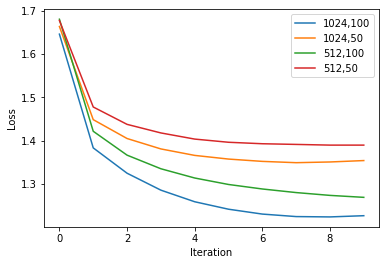

In [12]:
t = range(len(total_loss[0]))
plt.plot(t, total_loss[0], label='1024,100')
plt.plot(t, total_loss[1], label='1024,50')
plt.plot(t, total_loss[2], label='512,100')
plt.plot(t, total_loss[3], label='512,50')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

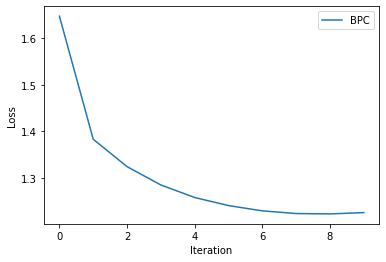

In [13]:
loss = total_loss[0]
draw_loss(loss)

In [121]:
total_loss.append(loss)
#(1024,100), (512,100), (256,100), (1024,50), (512,50), (256,50)

In [263]:
model.evaluate(train_dataset)

    1/19683 [..............................] - ETA: 22:08

AttributeError: 'Sequential' object has no attribute 'loss_functions'

In [139]:
model.evaluate(val_dataset)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [31]:
#print(tf.train.latest_checkpoint('./RNN_checkpoints'))
rnn_units = 512
model = build_RNN_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights('./RNN_512_100/ckpt_10')

#model.build(tf.TensorShape([1, None]))
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (1, None, 256)            16640     
_________________________________________________________________
simple_rnn (SimpleRNN)       (1, None, 512)            393728    
_________________________________________________________________
dense_10 (Dense)             (1, None, 65)             33345     
Total params: 443,713
Trainable params: 443,713
Non-trainable params: 0
_________________________________________________________________


In [35]:
print(generate_text(model, start_string=u"JULIET"))

JULIET:
Cousingrake.

KATURONY:
O heaven, I shalth.

TRANIA:
That merlpe in his slave your love of Gentlus sfillishal! Thou and Children! sild did that! I secried.

GLOUCESTER:
I careoou and in honours anove A reake.

EDRUD:
I down revented in envivel
some the suthee proud to gran, that that that true!
I seee to outhonest off, call chasselved ns weepings to soul:
Canning.

DUCHESI:
I boint
The ownil for and sumclus this his my dain;
Thou mess.
Thou folseth him, if your meant
That I reath with it, of storely
That that should shall's a comfretd,
I ho, for still your daintly day?

GAUNT:
I talk:
I have show fools to end, you'll
That Till sin me sofides and repeace;
Or, sir! Causer to joy seed; no well husband; I sids, to malla? thou speak of Biards is the happoner:
Thou and so, but thou hast in a die!
Will six, and throubled in my heaven thee see body'd the out, and you meet the romeffey'd the reass; my larged foot.

LUCIO:
But I away:
Then.

CORIOLANUS:
Why, in these consuments and comes